In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import wkw

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Paths

In [3]:
data_root = '../data/'
log_root = './__logs__/'

# Dataset

../data/2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif


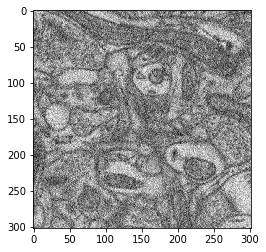

In [4]:
# Let's look at some data
print(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
img = plt.imread(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
plt.imshow(img, cmap='gray');

In [5]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [6]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = np.asarray(plt.imread(os.path.join(self.data_root, self.data_fnames[idx])))
        img = self._normalize(img)
        sample = SBEMCrop2dDataset._reshape_to_torch(img)
        return sample
    
    def _normalize(self, img):
        img = (np.asarray(img)-self.norm_params['mean'])/self.norm_params['std']
        return img
    
    @staticmethod
    def _reshape_to_torch(img):
        sample = torch.from_numpy(np.reshape(img, (1, img.shape[0], img.shape[1]))).float()
        return sample

## Instantiate dataset subclass

In [7]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)
len(sbem_dataset)

60

## Test dataset subclass

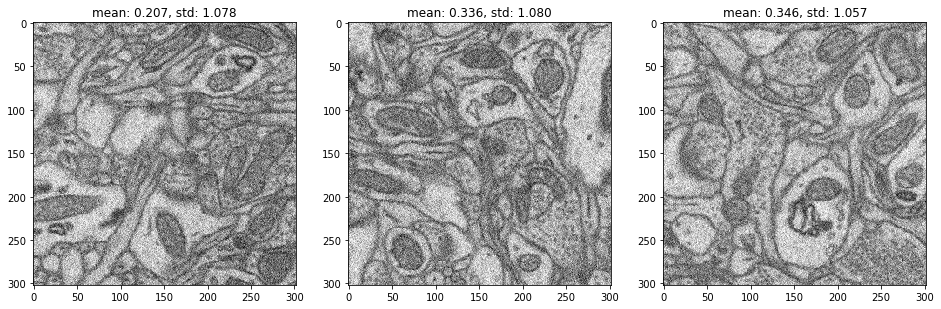

In [8]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    sample = sbem_dataset[i]
    img = sample.data.numpy().squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

In [9]:
img.dtype

dtype('float32')

# Model

## Define Model

In [10]:
def get_conv_pad(input_size, kernel_size, stride):
    padding = np.ceil(((stride-1)*input_size-stride+kernel_size)/2).astype(int)
    return padding

In [11]:
class Encoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*4, n_fmaps*8, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(17**2*n_fmaps*8, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_conv4(x)
        x = self.encoding_fc(x.reshape((-1, 1, 17**2*n_fmaps*8)))
        
        return x

In [12]:
class Decoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, output_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.decoding_fc = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 17**2*n_fmaps*8),
            torch.nn.ReLU())
        
        self.decoding_convt1 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*8, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU())
        
        self.decoding_convt2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*4, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU())

        self.decoding_convt3 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*2, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU())
        
        self.decoding_convt4 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps, 1, kernel_size, stride))
        
    def forward(self, x):
        
        x = self.decoding_fc(x)
        x = self.decoding_convt1(x.reshape((-1, n_fmaps*8, 17, 17)))
        x = self.decoding_convt2(x)
        x = self.decoding_convt3(x)
        x = self.decoding_convt4(x)
        
        return x

In [13]:
class AE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Instantiate Model, Loss and Optimizer

In [14]:
input_size=302
output_size=input_size
kernel_size=3
stride=1
n_fmaps=16
n_latent=5000
net = AE(
    Encoder_4_sampling_bn(input_size, kernel_size, stride, n_fmaps, n_latent), 
    Decoder_4_sampling_bn(output_size, kernel_size, stride, n_fmaps, n_latent))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)


## Utility functions

In [15]:
def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    input_cpu = inputs[idx].data.cpu()
    img_input = input_cpu.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    output_cpu = outputs[idx].data.cpu()
    img_output = output_cpu.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

# Train Model

In [16]:
trainloader = DataLoader(sbem_dataset, batch_size=10, shuffle=True, num_workers=2)
for i, data in enumerate(trainloader):
    print(data.shape)

torch.Size([10, 1, 302, 302])
torch.Size([10, 1, 302, 302])
torch.Size([10, 1, 302, 302])
torch.Size([10, 1, 302, 302])
torch.Size([10, 1, 302, 302])
torch.Size([10, 1, 302, 302])


In [16]:
trainloader = DataLoader(sbem_dataset, batch_size=10, shuffle=True, num_workers=2)
writer = SummaryWriter(log_root)
writer_int = 5
epoch_writer_int = 50
n_epoch = 50000
it = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        it += 1

        inputs = data
        inputs = inputs.cuda();
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        
        if (i+1) % writer_int == 0:
            avg_loss = running_loss / writer_int
            if (epoch+1) % epoch_writer_int == 0:
                print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(it, epoch, i+1, avg_loss))

            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('avg_loss', avg_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)

            running_loss = 0.0

it: 299 (epoch: 49, batch: 5), running loss: 1.124
it: 599 (epoch: 99, batch: 5), running loss: 1.084
it: 899 (epoch: 149, batch: 5), running loss: 0.814
it: 1199 (epoch: 199, batch: 5), running loss: 0.686
it: 1499 (epoch: 249, batch: 5), running loss: 0.630
it: 1799 (epoch: 299, batch: 5), running loss: 0.600
it: 2099 (epoch: 349, batch: 5), running loss: 0.580
it: 2399 (epoch: 399, batch: 5), running loss: 0.564
it: 2699 (epoch: 449, batch: 5), running loss: 0.551
it: 2999 (epoch: 499, batch: 5), running loss: 0.542
it: 3299 (epoch: 549, batch: 5), running loss: 0.535
it: 3599 (epoch: 599, batch: 5), running loss: 0.528
it: 3899 (epoch: 649, batch: 5), running loss: 0.522
it: 4199 (epoch: 699, batch: 5), running loss: 0.520
it: 4499 (epoch: 749, batch: 5), running loss: 0.516
it: 4799 (epoch: 799, batch: 5), running loss: 0.507
it: 5099 (epoch: 849, batch: 5), running loss: 0.504
it: 5399 (epoch: 899, batch: 5), running loss: 0.506
it: 5699 (epoch: 949, batch: 5), running loss: 0.49

Exception ignored in: <function _releaseLock at 0x2b7c0cdbab80>
Traceback (most recent call last):
  File "/u/alik/conda-envs/gen-EM/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 66814) exited unexpectedly

In [17]:
print(trainloader.batch_size)

10


In [18]:
#modelPath = os.path.join(log_root,'50KEpoch_v1.pt')
#torch.save(net,modelPath)

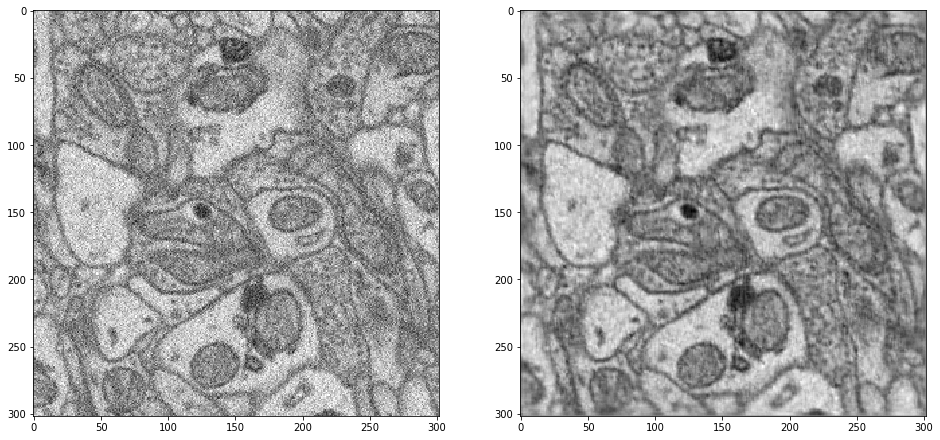

In [19]:
# Show input vs output
data2fig_subplot(inputs, outputs, 9);


(array([   57.,   200.,  1048.,  8096., 21896., 22431., 18768., 14542.,
         4045.,   121.]),
 array([-2.8912685 , -2.3212738 , -1.7512794 , -1.1812847 , -0.6112901 ,
        -0.04129553,  0.52869904,  1.0986936 ,  1.6686883 ,  2.2386827 ,
         2.8086774 ], dtype=float32),
 <a list of 10 Patch objects>)

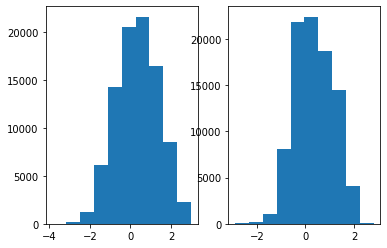

In [21]:
fig, axs = plt.subplots(1,2)
axs[0].hist(inputs[0].data.cpu().numpy().flatten())
axs[1].hist(outputs[0].data.cpu().numpy().flatten())

# Variational auto-encoder

In [ ]:
"""
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
"""